In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
from modules.representation_schemes import enc1d_features, get_PTR_features
from modules.function import get_metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
import json
import pickle
import torch

In [5]:
phases_file = 'Files_from_GTDL_paper/gao_data.txt'
[x0,dataY]=pickle.load(open(phases_file, 'rb'))
comps = [y.split(' ')[1] for y in x0]
y = np.array(dataY)

Check number of PCA components required

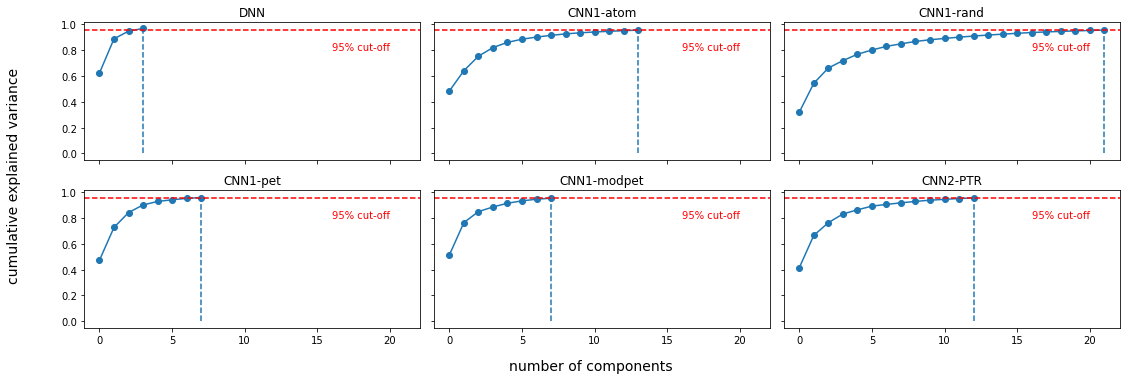

In [6]:
methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
component_dict, pca_dict = {},{}
fig, ax  = plt.subplots(2,3, sharey=True, sharex = True, figsize = (15,5))
ax = ax.ravel()
for i, method in enumerate(methods):
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method == 'dense':
        extracted = enc1d_features(comps,'dense')
    pca = PCA()
    features = pca.fit_transform(extracted)
    ind = np.argmax(np.cumsum(pca.explained_variance_ratio_)>0.95)
    ax[i].plot(np.cumsum(pca.explained_variance_ratio_)[:ind+1],marker = 'o')
    ax[i].vlines(ind,0,np.cumsum(pca.explained_variance_ratio_)[ind],linestyles='dashed')
    ax[i].axhline(y=0.95, color='r', linestyle='dashed')
    ax[i].text(16, 0.8, '95% cut-off', color = 'red', fontsize=10)
    ax[i].set_title(names[i],y=1)
    component_dict[method] = ind
    pca_dict[method] = pca.explained_variance_ratio_.tolist()

fig.text(0.5, -0.04, 'number of components', ha='center', fontsize=14)
fig.text(-0.04, 0.5, 'cumulative explained variance', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
with open('misc/pca_components.pkl','wb') as fid:
    pickle.dump(component_dict,fid)
with open('misc/pca_results.json','w') as fid:
    json.dump(pca_dict,fid)

Random Forest classifier

In [16]:
methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
method_dict = {}
mean_score_list = []
std_score_list = []
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method ==' dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    kfold = StratifiedKFold(n_splits=10, random_state=0,shuffle=True).split(features,y)#dataX
    randomforest = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=1000)
    score=[]
    fold_report = {}
    for k, (train, test) in enumerate(kfold):
        #print('\n\n 5-fold cross-validation: No.'+str(k+1))
        randomforest.fit(features[train], y[train])
        yte_pred=randomforest.predict(features[test])
        report = metrics.classification_report(y[test], yte_pred,output_dict=True)
        fold_micro_avg = report['weighted avg'].values()
        score.append(fold_micro_avg)
        fold_report['Fold_{}'.format(k)] = report



        #score.append(metrics.classification_report(y[test], yte_pred)) 
    method_dict[method] = fold_report
    score = pd.DataFrame(score,columns=['Precision','Recall','F1 Score','Support'])
    mean_score_list.append(score.mean().values)
    std_score_list.append(score.std().values)
    #print(score.mean(), score.std())

dense
atomic
random
pettifor
mod_pettifor
PTR


Text(0.5, 0.98, '10-fold CV on HEA phases dataset')

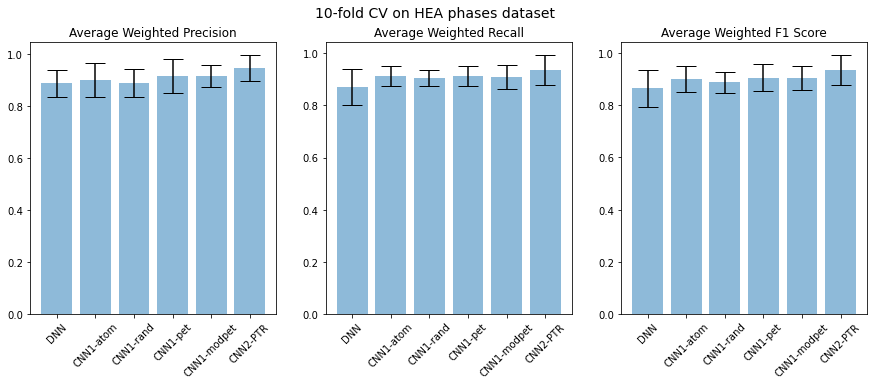

In [17]:
keys = ['Precision','Recall','F1 Score']
names = ['DNN','CNN1-atom','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
mean_score_list = np.array(mean_score_list)
std_score_list = np.array(std_score_list)
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax = ax.ravel()
for i,k in enumerate(keys):
    ax[i].bar(methods, mean_score_list[:,i], yerr = std_score_list[:,i],align='center', alpha=0.5, ecolor='black', capsize=10)
    ax[i].set_title('Average Weighted {}'.format(k))
    ax[i].set_xticklabels(names, rotation=45)
fig.suptitle('10-fold CV on HEA phases dataset', fontsize = 14)

In [15]:
phase_results_dict = {
    'names':names,
    'mean_f1_score':mean_score_list[:,-2].tolist(),
    'std_f1_score':std_score_list[:,-2].tolist()
}
with open('misc/phase_prediction_stats.json','w') as fid:
    json.dump(phase_results_dict,fid)

Statistical significance

In [13]:
methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
method_dict = {}
predicted_dict = {}
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method == 'dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    X_train, X_test, y_train, y_test = train_test_split(features,y,random_state=0,shuffle=True, test_size=0.2)
    randomforest = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=1000)    
    randomforest.fit(X_train, y_train)
    yte_pred=randomforest.predict(features)
    predicted_dict[method] = yte_pred

dense
atomic
random
pettifor
mod_pettifor
PTR


In [14]:
from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
bin_dict = {}
for k in predicted_dict.keys():
    yes =[]
    for i,ph in enumerate(predicted_dict[k]):
        if predicted_dict[k][i] == y[i]:
            yes.append(1)
        else:
            yes.append(0)
    bin_dict[k] = np.array(yes)
compare_keys = list(combinations(methods,2))
zero = np.ones((len(methods),len(methods)))
for key in compare_keys:
    
    contengency = np.zeros((2,2))
    a,b = key
    cl_ptr = bin_dict[a]
    cl_com = bin_dict[b]
    ind1 = np.argwhere(np.array(methods)==a)
    ind2 = np.argwhere(np.array(methods)==b)
    for i in range(len(cl_ptr)):
        if cl_ptr[i] == cl_com[i]== 1:
            contengency[0,0] +=1
        elif (cl_ptr[i] == 1)*(cl_com[i] == 0):
            contengency[0,1] += 1
        elif (cl_ptr[i] == 0)*(cl_com[i] == 1):
            contengency[1,0] += 1
        elif cl_ptr[i] == cl_com[i]== 0:
            contengency[1,1] += 1
    result = mcnemar(contengency, exact=True)
    alpha = 0.05
    zero[ind1,ind2] = result.pvalue
    if result.pvalue > alpha:
        
        print('Same proportions of errors (fail to reject H0) for PTR and {}'.format(key))
    else:
        print('Different proportions of errors (reject H0) for PTR and {}'.format(key))

Different proportions of errors (reject H0) for PTR and ('dense', 'atomic')
Different proportions of errors (reject H0) for PTR and ('dense', 'random')
Different proportions of errors (reject H0) for PTR and ('dense', 'pettifor')
Different proportions of errors (reject H0) for PTR and ('dense', 'mod_pettifor')
Different proportions of errors (reject H0) for PTR and ('dense', 'PTR')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'random')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'pettifor')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'mod_pettifor')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'PTR')
Same proportions of errors (fail to reject H0) for PTR and ('random', 'pettifor')
Same proportions of errors (fail to reject H0) for PTR and ('random', 'mod_pettifor')
Different proportions of errors (reject H0) for PTR and ('random', 'PTR')
Same proportions of errors (fail to reject H0) f

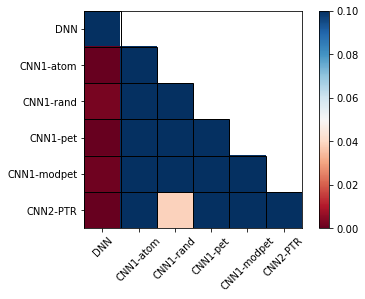

In [15]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
mask =  np.tri(zero.T.shape[0], k=-1)
A = np.ma.array(zero, mask=mask).T
truth = np.where(mask == 1)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(methods), 1))
ax1.set_yticks(np.arange(0, len(methods), 1))
# use dir(matplotlib.cm) to get a list of the installed colormaps
# the "_r" means "reversed" and accounts for why zero values are plotted as white
cmap = cm.get_cmap('RdBu')

#norm = MidPointNorm(midpoint=)
#cmap.set_bad('w')
plt.imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
for i in range(len(truth[0])):
    highlight_cell(truth[1][i],truth[0][i])
diag = [0,1,2,3,4,5]
for k in diag:
    highlight_cell(k,k)
ax1.set_xticklabels(names, rotation = 45)
ax1.set_yticklabels(names)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.colorbar()


In [13]:
results_dict_loc = 'results/results.json'
if os.path.exists(results_dict_loc):
    with open(results_dict_loc,'r') as fid:
        sup_results_dict = json.load(fid)
    temp_dict = {}
    temp_dict['mcnemar_hea_phase'] = {'names' : names, 'p_vals' : zero.tolist()}
    sup_results_dict = sup_results_dict|temp_dict
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)
else:
    sup_results_dict = {}
    sup_results_dict['mcnemar_hea_phase'] = {'names' : names, 'p_vals' : zero.tolist()}
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)
